In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
#loading the file
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar = dict(npz_file.items())
    

In [3]:
cifar.keys()

dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])

In [4]:
# Splitting the data that I am going to use into train/test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    cifar['overfeat'], cifar['labels'], 
    stratify = cifar['labels'], test_size = 1000, random_state = 0)

# Same for the pixels to be able to query them later
x_train_px, x_test_px, y_train, y_test = train_test_split(
    cifar['pixels'], cifar['labels'], 
    stratify = cifar['labels'], test_size = 1000,random_state = 0)

# Splitting the training set into train/validation
x_tr, x_val, y_tr ,y_val = train_test_split(
    x_train, y_train, stratify = y_train, test_size = 800, random_state = 0)
#Splitting same with the pixel data
x_tr_px, x_val_px, y_tr, y_val = train_test_split(
    x_train_px, y_train, stratify = y_train, test_size = 800, random_state = 0)

In [12]:
# I create the pipeline with the PCA as preproccesing and KNN as classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid

pca = PCA(n_components = 392) # these are the features needed to get 95% explained variance

knn = KNeighborsClassifier()

pipe = Pipeline([
                ('pca', pca), # PCA as preproccesing
                ('knn', knn)
                ])

grid =ParameterGrid({
    'knn__n_neighbors': np.arange(1,20), # number of neighbors
    'knn__p': [1,2] # L1 or L2
})

val_scores = [] # empty list to append the scores

# Grid search and appending the results to the dict
for params_dict in grid:
    
    pipe.set_params(**params_dict)
            
    pipe.fit(x_tr, y_tr)
    params_dict['validation accuracy'] = pipe.score(x_val, y_val)

    val_scores.append(params_dict)

In [13]:
# Putting the results in a dataframe
#reseting to index for easier query afterwards
scores_df = pd.DataFrame(val_scores)
scores_df = scores_df.sort_values(by='validation accuracy',ascending = False)
scores_df = scores_df.reset_index(drop = True)
scores_df

,knn__n_neighbors,knn__p,validation accuracy
0,19,2,0.76875
1,13,2,0.76875
2,16,2,0.76750
3,11,2,0.76750
4,14,2,0.76500
5,17,2,0.76250
6,12,2,0.76250
7,18,2,0.76000
8,9,2,0.75750
9,15,2,0.75750


In [14]:
# best parameters
best_k = scores_df.iloc[0, 0]
best_p = scores_df.iloc[0, 1]

#printing the best model
print('Top accuracy on validation set:{:.4f} with k= {} and distance metric: {}'\
      .format(scores_df.iloc[0, 2], best_k, best_p))

Top accuracy on validation set:0.7688 with k= 19 and distance metric: 2


In [15]:
from sklearn.pipeline import Pipeline
#using the best parameters on the entire data and fiting it to test set
knn = KNeighborsClassifier(
    n_neighbors=best_k,
    p=best_p  
    )

# Create the pipeline and fit it to training data
pipe = Pipeline([
        ('pca', pca),
        ('knn', knn)
        ])

pipe.fit(x_train, y_train)
test_acc = pipe.score(x_test, y_test)
# lower accuracy than the validation set but not very big to be unreasonable
print('k-NN accuracy (test set): {:.4f}'.format(test_acc))

k-NN accuracy (test set): 0.7810


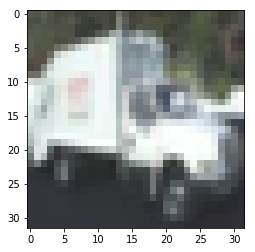

In [16]:
# doing pca transformation in one of the test images
# plotting it 
x_im = pca.transform(x_test[5].reshape(1,-1))
plt.imshow(x_test_px[5].reshape(32,32,3))

In [ ]:
x_te_px['pixels']

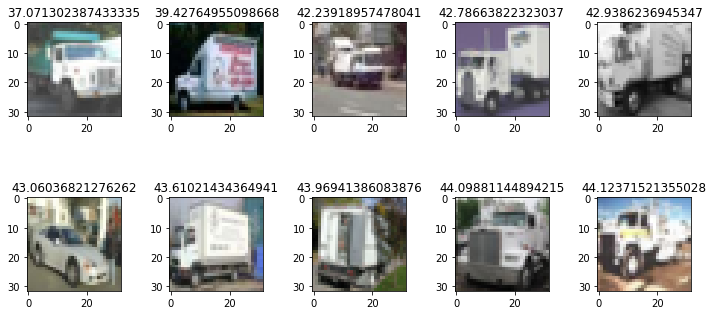

In [18]:
n_nei = knn.kneighbors(x_im, 10) # using the KNN from before i find the 10 closest neighbours
distances = n_nei[0][0]
indices = n_nei[1][0]
# and I plot them with their distances as titles
figs,axes = plt.subplots(nrows = 2, ncols = 5, figsize=(10,5)) 

for i, axis in enumerate(axes.flatten()):
    idx = indices[i]
    img_r = x_train_px[idx].reshape(32,32,3)
    axis.imshow(img_r)
    axis.set_title(distances[i])

plt.tight_layout()
plt.show()  